# Introduction to the Lagrangian Box Model

In this notebook, we will develop a simple box model for a Lagrangian particle. This model serves as a foundational tool to understand how various processes influence the evolution of a particle. We will start with a basic framework and gradually introduce more complex elements.

### Understanding Particle Dynamics in a Cube

Here, we simulate particles moving within a cubic space. When these particles collide, they coagulate. This initial model does not include processes like condensation, evaporation, or forces such as drag. However, these elements will be integrated in subsequent steps to enhance realism.

### Enhancing Particle Realism and Model Complexity

Currently, the particles lack realistic properties, but we plan to incorporate these features progressively. The model's complexity will also be scaled up, which is where the flexibility of the `particula.lagrangian` module becomes crucial.

### Leveraging PyTorch for Enhanced Computational Performance

This model is designed with a focus on PyTorch, allowing us to seamlessly switch between CPU and GPU computations. This capability becomes increasingly important as we add more particles and complexity to the model, necessitating the use of GPU for efficient computation.


In [1]:
# Code Section: Importing Necessary Libraries and Initializing Variables
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from particula.lagrangian import boundary, integration, collisions, particle_property, particle_pairs

# Initializing the Torch Generator and setting the data type
torch.manual_seed(1234)  # Set the seed for reproducibility
t_type = torch.float32

## Defining the System: Parameters and Initial Conditions

The first step in our simulation is to define the system. This involves setting up a combination of fixed parameters and initializing the conditions for our particles. These parameters include the total number of particles, time step for the simulation, mass of each particle, dimensions of the cubic space, and other physical properties. The initial positions and velocities of the particles are generated randomly within this defined space, laying the groundwork for the subsequent simulation dynamics.

In [2]:
# Setting up the Simulation Parameters and Initial Conditions

# Define fixed parameters
TOTAL_NUMBER_OF_PARTICLES = 500
TIME_STEP = 0.01
SIMULATION_TIME = 100
MASS = 3
CUBE_SIDE = 50
speed = 5
save_points = 50

# Initialize particle positions randomly within the cube
position = torch.rand(
    3,
    TOTAL_NUMBER_OF_PARTICLES,
    dtype=t_type) * CUBE_SIDE - CUBE_SIDE / 2

# Initialize particle velocities randomly
velocity = torch.rand(3, TOTAL_NUMBER_OF_PARTICLES,
                      dtype=t_type) * speed - speed / 2

# Initialize force as zero for all particles
force = torch.zeros(3, TOTAL_NUMBER_OF_PARTICLES, dtype=t_type)

# Set constant mass and density for all particles
mass = torch.ones(TOTAL_NUMBER_OF_PARTICLES, dtype=t_type) * MASS
density = torch.ones(TOTAL_NUMBER_OF_PARTICLES, dtype=t_type) * 1

# Generate indices for particles, could be integer type
indices = torch.arange(TOTAL_NUMBER_OF_PARTICLES, dtype=t_type)  # could be int

# Calculate the total number of iterations for the simulation
total_iterations = int(SIMULATION_TIME / TIME_STEP)

# Initialize a tensor to track the total mass over iterations
total_mass = torch.zeros(total_iterations, dtype=t_type)

# Define gravity acting on all particles
gravity = torch.tensor(
    [0, -9.81, 0]).repeat(TOTAL_NUMBER_OF_PARTICLES, 1).transpose(0, 1)

## Setting Up Data Saving Mechanism

To effectively monitor and analyze the simulation, we will record specific variables at predetermined intervals. In this case, we'll focus on saving the position and mass of each particle. These variables will be captured at a set number of 'save points' throughout the simulation, allowing us to track the dynamic changes over time.

In [3]:
# Initializing Arrays for Saving Position and Mass Data

# Create arrays to store position and mass data at each save point
save_position = np.zeros((3, TOTAL_NUMBER_OF_PARTICLES, save_points))
save_mass = np.zeros((TOTAL_NUMBER_OF_PARTICLES, save_points))

# Determine which iterations will correspond to the save points
save_iterations = np.linspace(0, total_iterations, save_points, dtype=int)

## Executing the Box Model Simulation

With our system defined and data saving mechanisms in place, we now proceed to run the simulation. The process involves a series of steps that are iteratively executed to simulate the dynamics of the particles within the box. The steps are as follows:

- Boundary Check: Verify if any particles have moved outside the boundaries of the box and handle accordingly.
- Center Distance Calculation: Compute the pairwise distances between particles to their center.
- Surface Distance Calculation: Determine the pairwise distances from the surfaces of the particles.
- Collision Detection: Identify instances where particles collide with each other.
- Coalescence: Merge particles that have collided, simulating coalescence.
- Force Calculations: Apply force calculations to the particles, influencing their motion.
- Motion Integration: Integrate the equations of motion to update the position and velocity of each particle.
- Data Recording: At designated intervals, save the position and mass data of the particles for later analysis.

In [4]:
# Initialize counter for saving data
save_counter = 0
start_time = time.time()
# Start the simulation
for i in range(total_iterations):


    # Calculate pairwise distances between particles
    distance_matrix = particle_pairs.calculate_pairwise_distance(
        position=position)

    # Adjust distances for the radius of each particle (surface-to-surface
    # distance)
    radius = particle_property.radius_calculation(mass=mass, density=density)
    distance_matrix -= radius.unsqueeze(1) + radius.unsqueeze(0)

    # Identify pairs of particles that have collided
    valid_collision_indices_pairs = collisions.find_collisions(
        distance_matrix=distance_matrix, indices=indices, mass=mass)

    if valid_collision_indices_pairs.shape[0] > 0:
        # Coalesce particles that have collided and update their velocity and
        # mass
        velocity, mass = collisions.coalescence(
            position=position,
            velocity=velocity,
            mass=mass,
            radius=radius,
            collision_indices_pairs=valid_collision_indices_pairs)

    # Calculate the force acting on the particles (e.g., gravity)
    force = mass * gravity

    # Integrate the equations of motion to update position and velocity
    position, velocity = integration.leapfrog(
        position=position, velocity=velocity, force=force, mass=mass, time_step=TIME_STEP)

    # Apply boundary conditions for the cube (wrap-around)
    position = boundary.wrapped_cube(position=position, cube_side=CUBE_SIDE)

    # Save the position and mass data at designated save points
    if i == save_iterations[save_counter]:
        save_position[:, :, save_counter] = position.detach().numpy()
        save_mass[:, save_counter] = mass.detach().numpy()
        save_counter += 1

# Perform a final save of the position and mass data
save_position[:, :, -1] = position.detach().numpy()
save_mass[:, -1] = mass.detach().numpy()

# Calculate the total simulation time
end_time = time.time()
print(f"Total wall time: {end_time - start_time} seconds")
print(f"Ratio of wall time to simulation time: {(end_time - start_time) / SIMULATION_TIME}")

Total wall time: 19.37943959236145 seconds
Ratio of wall time to simulation time: 0.1937943959236145


## Visualizing the Final 3D Positions of Particles

In the final step of our analysis, we focus on visualizing the 3D positions of the particles at the end of the simulation. To accurately represent the final state, we will exclude particles that have effectively zero mass, as these have merged with other particles during the coalescence process. This visualization will provide us with an insightful view of the particle distribution and the results of the dynamic interactions that have occurred throughout the simulation.

Number of particles at the end: 64


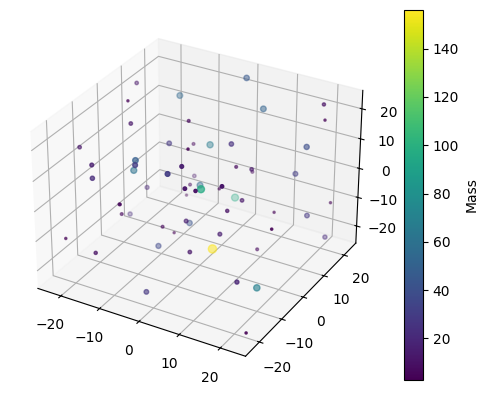

In [5]:
# Processing the Final Data for Visualization

# Select the final time index for the data
time_index = -1
position_final = save_position[:, :, time_index]
mass_final = save_mass[:, time_index]

# Filter out particles with zero mass
filter_zero_mass = mass_final > 0

# Calculate the radius and area of each particle
radius_final = particle_property.radius_calculation(mass=mass_final, density=density)
particle_area = np.pi * radius_final**2

# Display the number of remaining particles
print(f"Number of particles at the end: {filter_zero_mass.sum()}")

# Creating a 3D Plot for Visualization
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Choose a color map for the scatter plot
cmap = plt.cm.viridis

# Plot the final positions of particles with non-zero mass
scatter_plot = ax.scatter(
    position_final[0, filter_zero_mass],
    position_final[1, filter_zero_mass],
    position_final[2, filter_zero_mass],
    c=mass_final[filter_zero_mass],
    cmap=cmap,
    s=particle_area[filter_zero_mass]  # Particle size based on area
)

# Set axis limits based on cube dimensions
ax.set_xlim(-CUBE_SIDE / 2, CUBE_SIDE / 2)
ax.set_ylim(-CUBE_SIDE / 2, CUBE_SIDE / 2)
ax.set_zlim(-CUBE_SIDE / 2, CUBE_SIDE / 2)

# Add a color bar indicating particle mass
color_bar = plt.colorbar(scatter_plot, ax=ax)
color_bar.set_label('Mass')

# Show the plot with optimized layout
plt.show()
fig.tight_layout()

## Analyzing the Mass Distribution of Particles

Next, we turn our attention to understanding how the mass distribution of the particles has evolved over the course of the simulation. To achieve this, we will analyze the mass data normalized by the initial MASS value. This normalization allows us to observe changes in the mass distribution as multiples of the initial mass, providing insights into the extent of coalescence and mass variation among the particles.


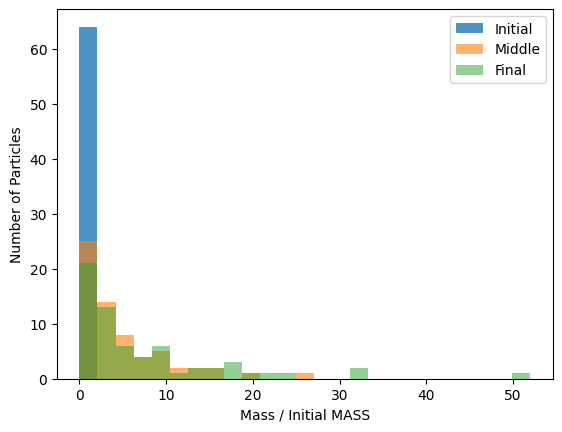

In [6]:
# Visualizing the Mass Distribution at Different Stages

# Create a new figure for the histogram
fig = plt.figure()
ax = fig.add_subplot()

# Normalizing by initial MASS to observe distribution changes
normalized_mass = save_mass[filter_zero_mass, :] / MASS
max_mass = normalized_mass.max()

# Plot histograms of mass distribution at different stages
ax.hist(normalized_mass[:, 0], bins=25,
        alpha=0.8, label='Initial', range=(0, max_mass))
ax.hist(normalized_mass[:, 24], bins=25,
        alpha=0.6, label='Middle', range=(0, max_mass))
ax.hist(normalized_mass[:, -1], bins=25,
        alpha=0.5, label='Final', range=(0, max_mass))

# Setting labels and title for the plot
ax.set_xlabel('Mass / Initial MASS')
ax.set_ylabel('Number of Particles')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()

# Adjust layout for optimal visualization
fig.tight_layout()

## Summary of the Lagrangian Particle Simulation

In this Jupyter Notebook, we have explored the dynamics of a Lagrangian particle system within a defined cubic space. Our focus has been on simulating and analyzing the interactions and evolution of particles under a set of initial conditions and physical laws. Here is a brief overview of what we covered:

### System Definition and Initialization
- We began by defining the simulation space and initial conditions for our particle system. This included setting parameters such as the number of particles, mass, and dimensions of the cubic space, as well as initializing the positions and velocities of the particles.

### Simulation Process
- The core of our simulation involved a series of iterative steps to simulate particle dynamics. These steps included checking boundary conditions, calculating distances, detecting and handling collisions, coalescing particles, applying forces, and integrating the equations of motion.

### Data Saving and Analysis
- Throughout the simulation, we saved key data points, such as the position and mass of particles at specified intervals. This allowed us to track and analyze the changes in the system over time.

### Visualization and Interpretation
- We utilized various visualization techniques to interpret the simulation results. This included creating 3D plots to visualize the final positions of particles and histograms to analyze the distribution of mass at different stages of the simulation.

### Insights Gained
- The simulation provided valuable insights into the behavior of particles in a Lagrangian framework. We observed how particles interact, coalesce, and evolve over time under the influence of set physical parameters and forces.